In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
import re
import statistics

plt.style.use('ggplot')

# Args

In [2]:
def add_scores_for_unknown_chains(sim_tra, sim_trb):
    sim_tra = sim_tra.T
    sim_trb = sim_trb.T

    sim_tra['unknown'] = 0
    sim_trb['unknown'] = 0

    sim_tra = sim_tra.T
    sim_trb = sim_trb.T

    sim_tra['unknown'] = 0
    sim_trb['unknown'] = 0

In [3]:
def get_unique_entries(df):
    return np.where((df.cdr3_TRA==a) & (df.cdr3_TRB==b), False, True) # OBS! AND or OR?

In [4]:
def add_similarity_scores(ai,bi):
    mat_a = sim_tra.loc[ai, a].reset_index(drop=True).T.reset_index(drop=True).T
    mat_b = sim_trb.loc[bi, b].reset_index(drop=True).T.reset_index(drop=True).T
    
    return mat_a.add(mat_b)

In [5]:
def get_intra_similarity(cdr3_TRAs, cdr3_TRBs):
    unique_entries = get_unique_entries(group) #np.where((group.cdr3_TRA==a) & (group.cdr3_TRB==b), False, True)
    
    intra_a = group[unique_entries].cdr3_TRA
    intra_b = group[unique_entries].cdr3_TRB
    
    combined_similarity = add_similarity_scores(intra_a, intra_b) #np.delete(cdr3_TRAs, index), np.delete(cdr3_TRBs, index)
    
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

In [6]:
def get_intra_similarity(cdr3_TRAs, cdr3_TRBs):
    unique_entries = get_unique_entries(group) #np.where((group.cdr3_TRA==a) & (group.cdr3_TRB==b), False, True)
    
    intra_a = group[unique_entries].cdr3_TRA
    intra_b = group[unique_entries].cdr3_TRB
    
    combined_similarity = add_similarity_scores(intra_a, intra_b) #np.delete(cdr3_TRAs, index), np.delete(cdr3_TRBs, index)
    
    return combined_similarity.to_list()

In [7]:
def get_inter_similarity(cdr3_TRAs, cdr3_TRBs):
    # OBS! make sure the size to sample from matches the number og unique entries intra_similarity!
    sample_size = sum(get_unique_entries(group))
    unique_entries =  get_unique_entries(inter_chains) #np.where((inter_chains.cdr3_TRA==a) & (inter_chains.cdr3_TRB==b), False, True)
    
    inter_sample = random.sample(inter_chains[unique_entries].index.to_list(), sample_size)
    
    inter_a = inter_chains.loc[inter_sample, 'cdr3_TRA'].values
    inter_b = inter_chains.loc[inter_sample, 'cdr3_TRB'].values
    
    combined_similarity = add_similarity_scores(inter_a, inter_b)
    
    return {'score': combined_similarity.max(),
            'fraction': sum(combined_similarity > 1.8)/len(combined_similarity)}

In [8]:
def paired_t_test(x1 ,x2):
    if len(x1) != len(x2):
        sample_size = min(len(x1), len(x2))
        x1 = random.sample(x1, sample_size)
        x2 = random.sample(x2, sample_size)
        
    print(len(x1), len(x2))
    
    statistic, pvalue = stats.ttest_rel(x1, x2)
    
    if (pvalue/2.0 < 0.05) & (statistic > 0) & (len(x1) > 9):
        return {'test':True, 'pvalue':pvalue}
    else:
        return {'test':False, 'pvalue':pvalue}

In [9]:
def add_number_of_observations(intra_lst, inter_lst):
    for box, lst in enumerate([intra_lst, inter_lst], start=1):
        if len(lst) > 0:
            median = statistics.median(lst)
            plt.text(box, median, "n: %i" %len(lst), ha='center', va='bottom')

In [10]:
def add_significance_bar(intra_lst, inter_lst):
    t = paired_t_test(intra_lst, inter_lst)#['pvalue']
    print(t)
    
    if t['test'] and t['pvalue'] < 0.05:
        pass
    else:
        return
    
    y0 =  max(max(intra_lst), max(inter_lst))
    y1 = y0 * 1.02
    y2 = y0 * 1.025
    y3 = y0 * 1.03
    y4 = y0 * 1.035

    plt.plot([1,1,2,2], [y1,y2,y2,y1], lw=1.5, c='k')
    plt.text(1.5, y3, "p = %.6f" %t['pvalue'], ha='center', va='bottom', color='k')
    plt.plot(1, y4)

In [28]:
def plot_boxplot(intra_lst, inter_lst, title, save=True):
    
    plt.figure(figsize=(3,5))
    plt.boxplot([intra_lst, inter_lst], labels=['imputed', 'original'], widths=(0.5, 0.5))
    
    plt.title(title)
    plt.xlim(0.6, 2.4)
    #plt.ylim(-0.1, 2.1)
    plt.ylabel("Similarity")
    
    add_number_of_observations(intra_lst, inter_lst)
    add_significance_bar(intra_lst, inter_lst)
    if save:
        plt.savefig(directory + 'compare_before_and_after_similarity/boxplot_{}.pdf'.format(title), bbox_inches='tight')
    plt.show()

In [29]:
def plot_pieplot(significance_count, total_peptides, title):
    plt.pie([sum(significance_count), total_peptides-sum(significance_count)],
            labels=['significant difference', 'insignificant'],
            autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * total_peptides / 100, p))
    plt.title("Distribution of significant outcomes (%i)" %total_peptides)
    plt.savefig(directory + 'pieplot_{}.pdf'.format(title), bbox_inches='tight')
    plt.show()

In [61]:
EXP = "exp3"

In [62]:
TYPE = 'imputed_new-clonotype'

In [63]:
directory = "stats/{}/{}/".format(EXP, TYPE)

# Input

In [64]:
UNIQUE_GEM = directory + 'unique_gems.lst'

In [65]:
INPUT_ORG = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/" + EXP + "_CAT_IONTORRENT_KMA_AKB/tables/tcr_barcode.cleaned.csv"
INPUT_TRA = directory + 'imputed_TRA.csv'
INPUT_TRB = directory + 'imputed_TRB.csv'
INPUT_PEP = directory + 'imputed_PEP.csv'

In [66]:
SIM_TRA    = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_tra.{}.tab".format(EXP)
SIM_TRB    = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/kernel_similarity_trb.{}.tab".format(EXP)

In [67]:
PEPTIDES   = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3.2.2_MHC_IONTORRENT/barcode_library/barcode_specificity_annotations.xlsx"

# Output

# Load

In [68]:
unique_gems = np.loadtxt(UNIQUE_GEM, dtype=str)

In [69]:
df = pd.read_csv(INPUT_ORG)
df = df[df.gem.isin(unique_gems)]

In [70]:
df_tra = pd.read_csv(INPUT_TRA)
df_trb = pd.read_csv(INPUT_TRB)
df_pep = pd.read_csv(INPUT_PEP)

In [71]:
sim_tra = pd.read_csv(SIM_TRA, index_col=0)
sim_trb = pd.read_csv(SIM_TRB, index_col=0)

sim_tra = sim_tra[~sim_tra.index.duplicated()]
sim_trb = sim_trb[~sim_trb.index.duplicated()]

In [72]:
input_peptides = pd.read_excel(PEPTIDES)
total_peptides = len(input_peptides.Sequence.unique()) - 1

In [73]:
df_pep

,gem,ct,cdr3_TRA,cdr3_TRB,peptide_HLA,imputed_PEP,imputed_umi_PEP
0,ACAGCCGTCTTGTCAT-1,23.0,CAVRDNNQGGKLIF,CSAHPPGQGWEKLFF,TLDEKVAELV A0201,VTEHDTLLY A0101,3.0
1,CGACTTCTCACTTATC-1,13.0,CAARPGAQKLVF,CASSLEGGGTPYEQYF,QIDVSQFGSY A0101,VTEHDTLLY A0101,2.0
2,GGCAATTCAGTATCTG-1,385.0,CAVVNRDDKIIF,CASSPGGPQSQQFF,VTEHDTLLY A0101,KTWGQYWQV A0201,2.0
3,GGGTTGCTCGGAAACG-1,23.0,CAVRDNNQGGKLIF,CSAHPPGQGWEKLFF,SLAAYIPRL A0201,VTEHDTLLY A0101,6.0
4,TTCCCAGAGAATCTCC-1,351.0,CAVCSDYKLSF,CASGDGGNEQFF,VTEHDTLLY A0101,KTWGQYWQV A0201,2.0


# Process

In [74]:
df = df.replace('unknown', np.nan).dropna(subset=['cdr3_TRA', 'cdr3_TRB'])

In [75]:
gb = df.groupby('peptide_HLA')

In [76]:
 gb.get_group('ELRRKMMYM B0801')

,gem,clonotype,num_clonotype,ct,length_TRA,cdr3_TRA,umi_count_TRA,umi_count_lst_TRA,delta_umi_TRA,cdr3_lst_TRA,...,v40,v41,v5,v6,v7,v8,v9,gems_per_specificity,gems_per_clonotype,binding_concordance
236,ACGCCGAAGGTGACCA-1,clonotype115,115.0,196.0,488.0,CLVGYNTDKLIF,7.0,[7],100.0,['CLVGYNTDKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000
269,ACTATCTAGCTCAACT-1,clonotype13,13.0,48.0,631.0,CAFIGYTGKLIF,3.0,[3],100.0,['CAFIGYTGKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,0.333333
487,AGTGGGAAGAAGGTTT-1,clonotype22,22.0,196.0,470.0,CLVGYNTDKLIF,2.0,"[1, 2]",50.0,['CVVSAGGNARLMF' 'CLVGYNTDKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,0.375000
730,CACCACTAGGATGCGT-1,None,0.0,23.0,618.0,CAVRDNNQGGKLIF,10.0,[10],100.0,['CAVRDNNQGGKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1177,0.005947
1396,CTGGTCTTCCACTGGG-1,clonotype22,22.0,36.0,478.0,CVVSAGGNARLMF,4.0,"[4, 4]",0.0,['CLVGYNTDKLIF' 'CVVSAGGNARLMF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,0.375000
1420,CTTAGGATCCGTTGCT-1,clonotype505,505.0,959.0,562.0,CAAYGQNFVF,3.0,[3],100.0,['CAAYGQNFVF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000
1809,GGACAAGGTCTCACCT-1,clonotype22,22.0,36.0,478.0,CVVSAGGNARLMF,4.0,"[3, 4]",25.0,['CLVGYNTDKLIF' 'CVVSAGGNARLMF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,0.375000
1883,GGGAGATGTACAGTTC-1,clonotype13,13.0,48.0,484.0,CAFIGYTGKLIF,1.0,[1],100.0,['CAFIGYTGKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,0.333333
2195,TAGAGCTGTAACGCGA-1,None,0.0,3665.0,618.0,CAVRDNNQGGKLIF,11.0,"[3, 11]",72.0,['CAARPGAQKLVF' 'CAVRDNNQGGKLIF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1177,0.005947
2313,TCCACACAGTACGCGA-1,clonotype20,20.0,36.0,478.0,CVVSAGGNARLMF,6.0,[6],100.0,['CVVSAGGNARLMF'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11,0.090909


# Main

0 0
{'test': False, 'pvalue': nan}


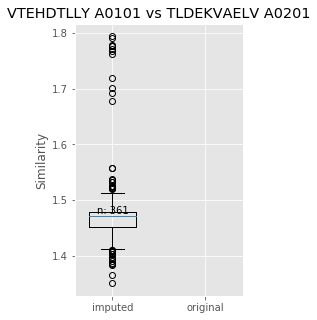

105 105
{'test': True, 'pvalue': 0.00023782575846377626}


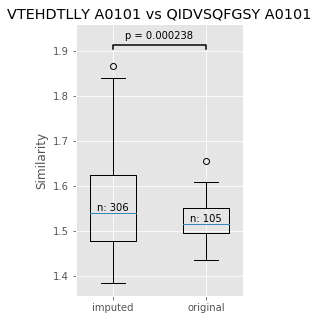

67 67
{'test': True, 'pvalue': 2.514187373330433e-09}


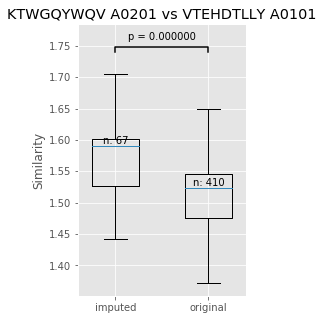

124 124
{'test': True, 'pvalue': 3.593344474775858e-08}


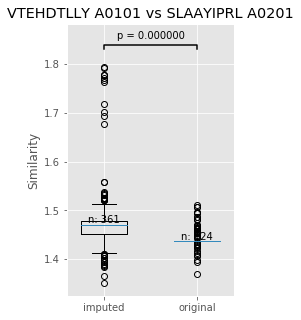

68 68
{'test': True, 'pvalue': 4.9622041709877355e-14}


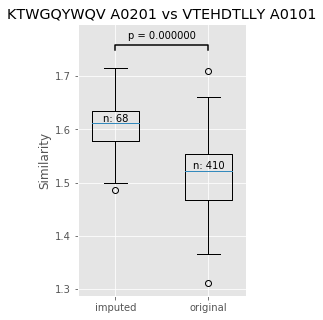

In [77]:
for index, row in df_pep.iterrows():
    intra_score = []
    for peptide in row[['imputed_PEP', 'peptide_HLA']]:
        group = gb.get_group(peptide)

        a, b = row[['cdr3_TRA','cdr3_TRB']]

        cdr3_TRAs = group.cdr3_TRA.values
        cdr3_TRBs = group.cdr3_TRB.values
        
        intra_score += [get_intra_similarity(cdr3_TRAs, cdr3_TRBs)]
    
    plot_boxplot(intra_score[0], intra_score[1], '{} vs {}'.format(row.imputed_PEP, row.peptide_HLA), save=True)

71 71
{'test': False, 'pvalue': 0.20252820846893163}


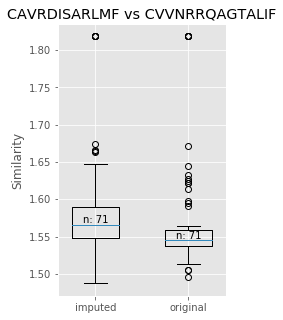

65 65
{'test': True, 'pvalue': 1.3417874184890687e-06}


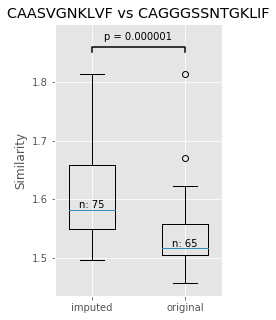

13 13
{'test': False, 'pvalue': 0.021821374107585362}


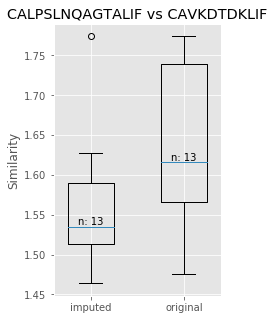

7 7
{'test': False, 'pvalue': 0.9391673160541336}


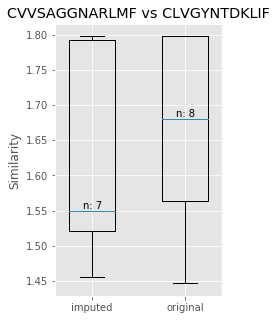

7 7
{'test': False, 'pvalue': 0.8930620421607687}


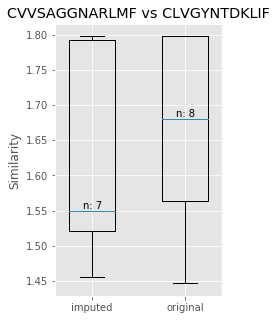

306 306
{'test': True, 'pvalue': 0.03976101553099669}


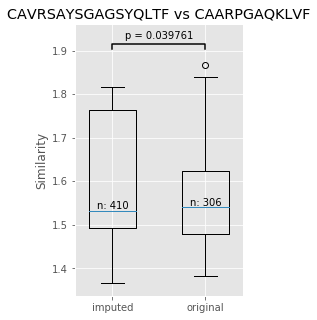

In [78]:
for index, row in df_tra.iterrows():
    intra_score = []
    for a in row[['cdr3_TRA', 'imputed_TRA']]:
        group = gb.get_group(row.peptide_HLA)

        b = row.cdr3_TRB

        cdr3_TRAs = group.cdr3_TRA.values
        cdr3_TRBs = group.cdr3_TRB.values
        
        intra_score += [get_intra_similarity(cdr3_TRAs, cdr3_TRBs)]
    
    plot_boxplot(intra_score[0], intra_score[1], '{} vs {}'.format(row.cdr3_TRA, row.imputed_TRA), save=True)

In [79]:
for index, row in df_trb.iterrows():
    intra_score = []
    group = gb.get_group(row.peptide_HLA)
    print(row.peptide_HLA)
    for b in row[['cdr3_TRB', 'imputed_TRB']]:

        a = row.cdr3_TRA

        cdr3_TRAs = group.cdr3_TRA.values
        cdr3_TRBs = group.cdr3_TRB.values
        
        intra_score += [get_intra_similarity(cdr3_TRAs, cdr3_TRBs)]
    
    plot_boxplot(intra_score[0], intra_score[1], '{} vs {}'.format(row.cdr3_TRB, row.imputed_TRB), save=True)

In [78]:
df_trb

,gem,ct,cdr3_TRA,cdr3_TRB,peptide_HLA,imputed_TRB
0,CACACAATCTTCAACT-1,1378.0,CAERDSWGKFQF,CASSSRGADSNQPQHF,NLVPMVATV A0201,CSGDLGRQNTEAFF
1,CAGCGACAGCACCGTC-1,2760.0,CAARPGAQKLVF,CASSLGQGQGETQYF,VTEHDTLLY A0101,CASSLEGGGTPYEQYF
2,CTGAAACGTCGATTGT-1,1360.0,CAVKDTDKLIF,CATSDFGGRAEGDEQFF,YVLDHLIVV A0201,CASSPILAGVDTQYF
3,TATTACCGTGGCGAAT-1,3202.0,CAASNGNQGGKLIF,CASSLEFDRRPYEQYF,VTEHDTLLY A0101,CASSSRGVGGRPHEQYF
4,TCAGATGGTACAGACG-1,2651.0,CAVRDNNQGGKLIF,CASSPAGNYNEQFF,VTEHDTLLY A0101,CSAHPPGQGWEKLFF


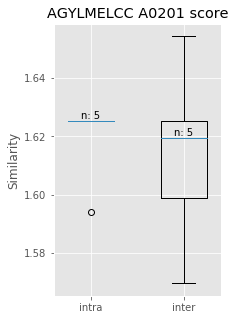

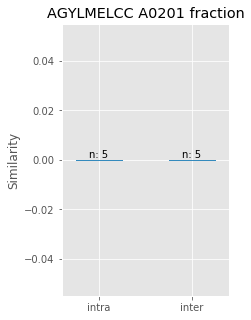

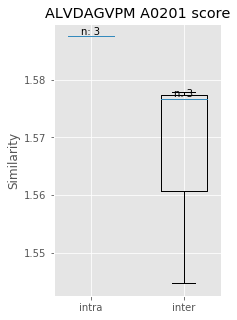

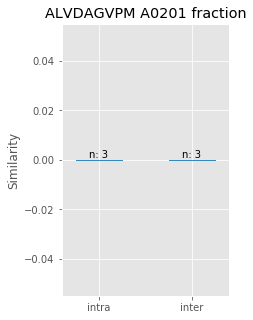

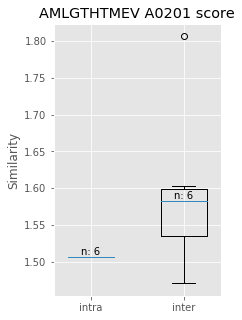

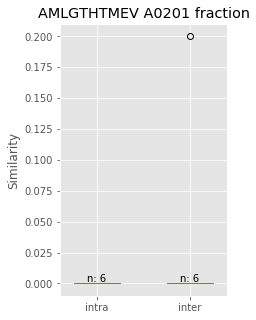

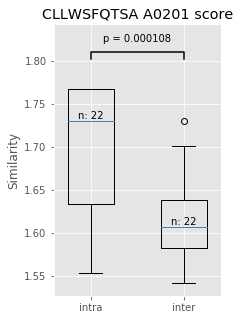

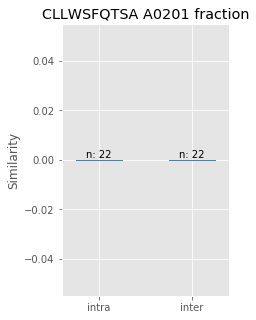

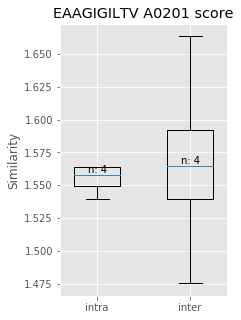

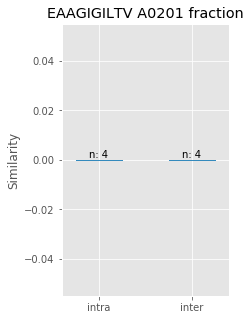

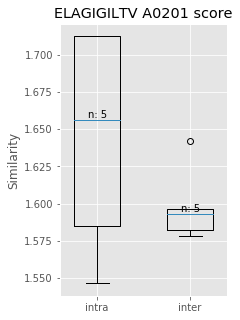

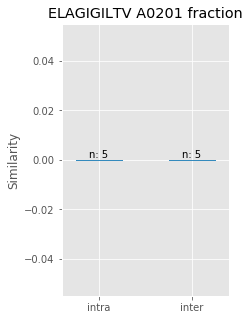

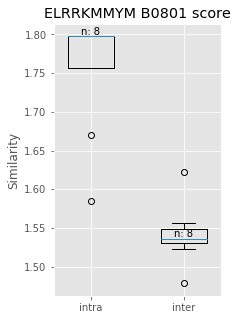

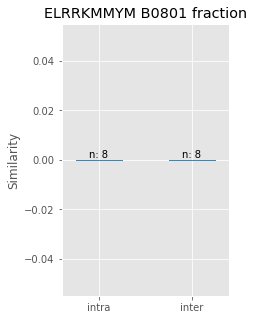

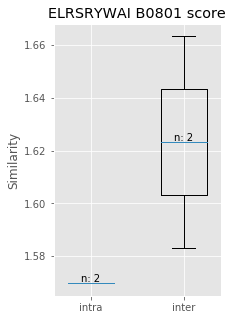

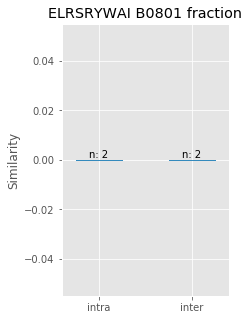

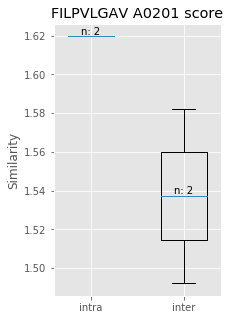

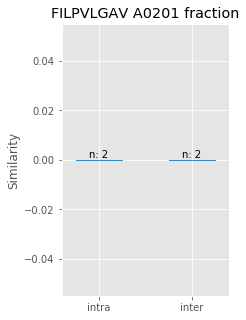

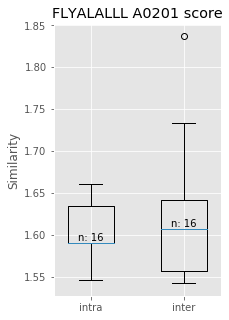

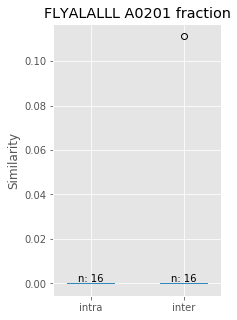

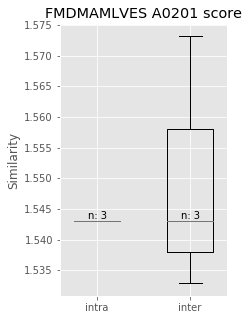

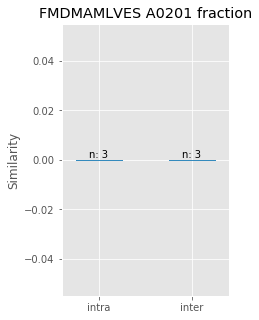

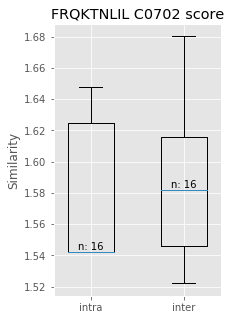

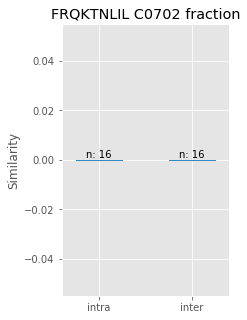

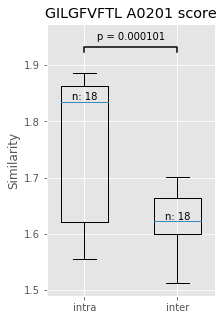

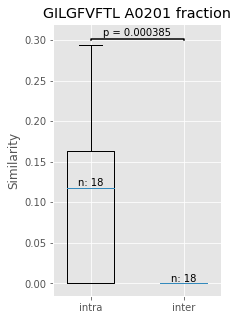

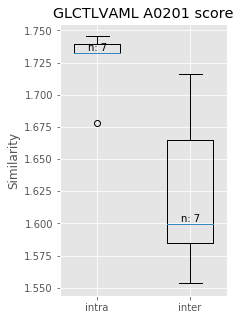

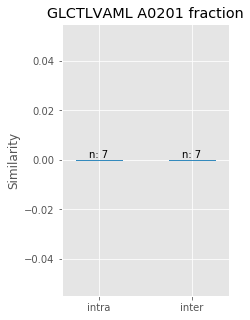

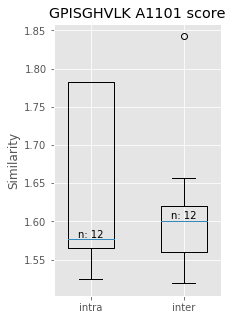

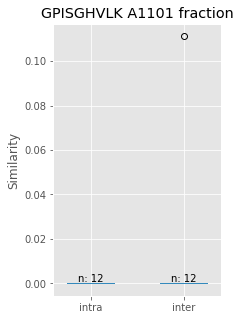

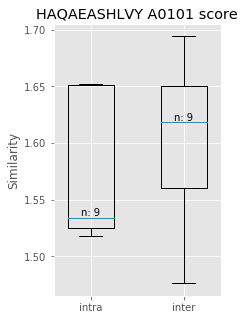

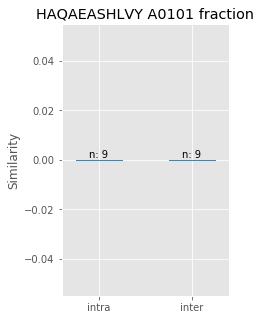

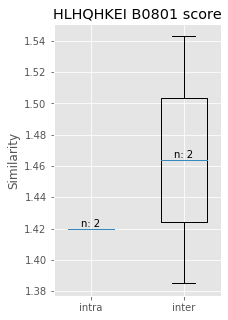

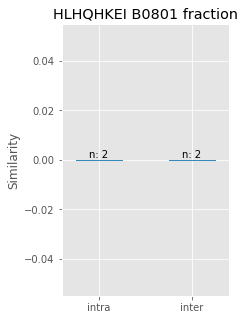

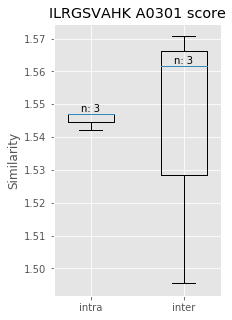

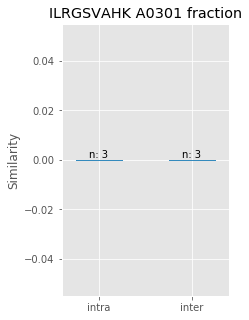

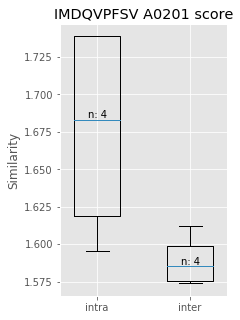

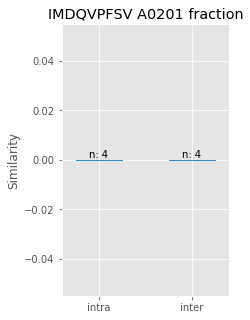

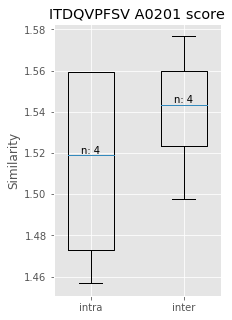

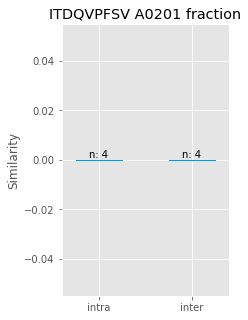

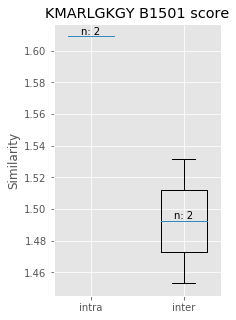

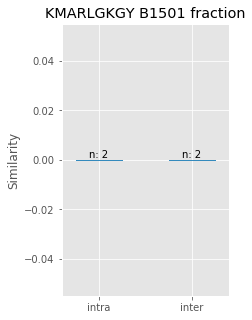

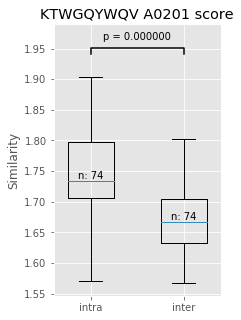

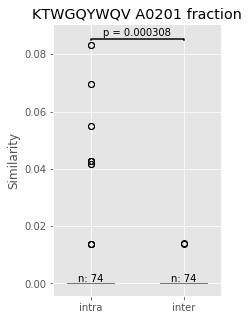

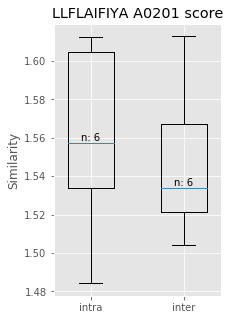

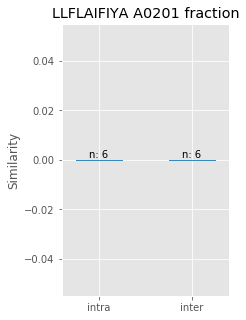

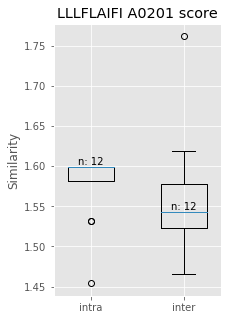

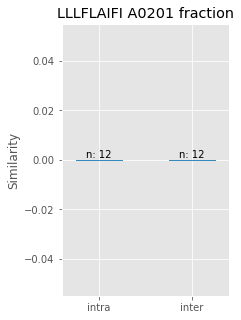

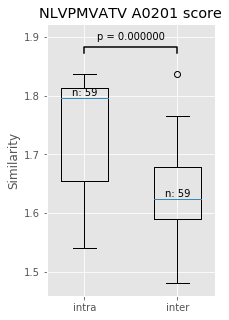

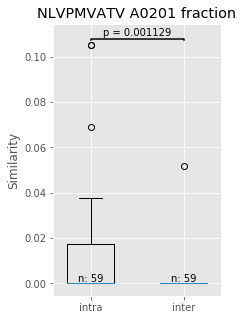

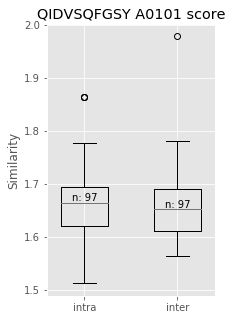

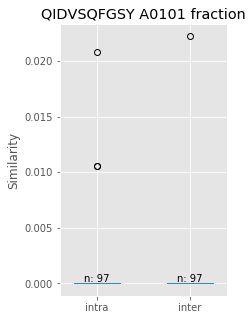

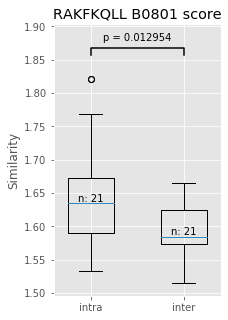

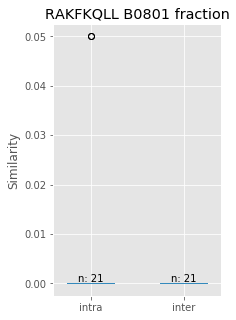

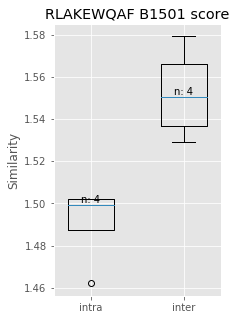

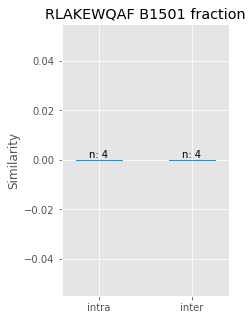

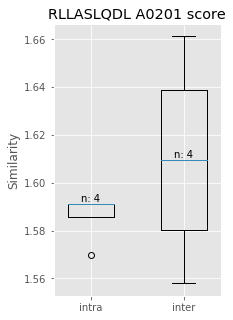

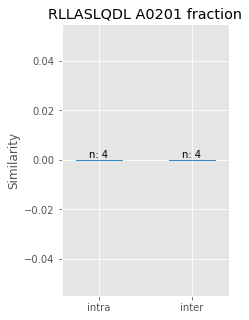

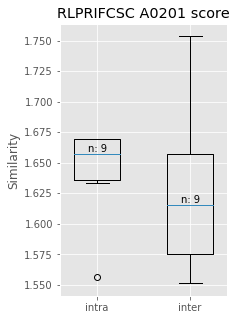

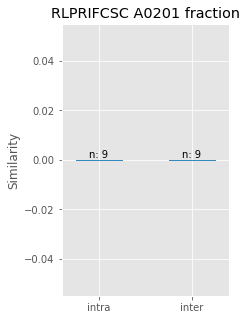

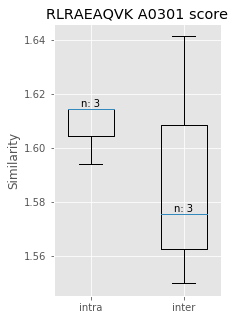

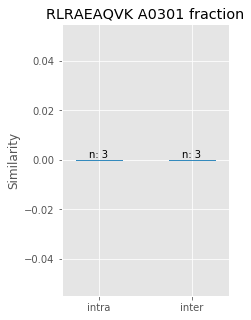

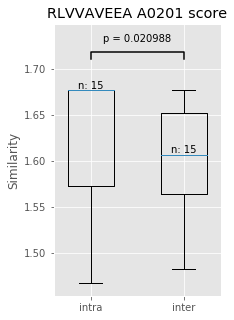

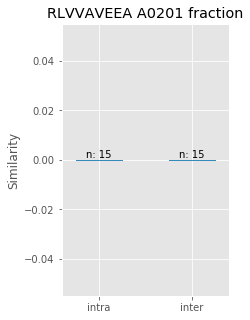

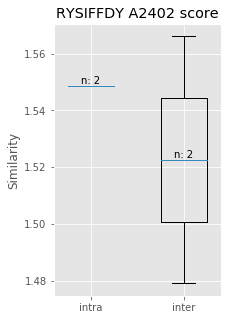

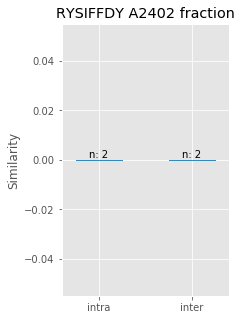

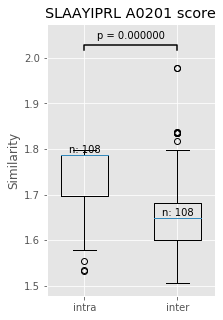

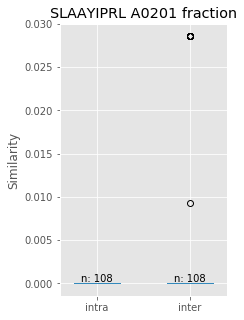

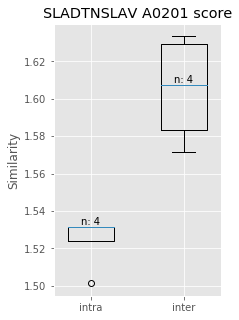

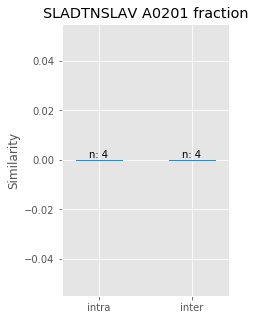

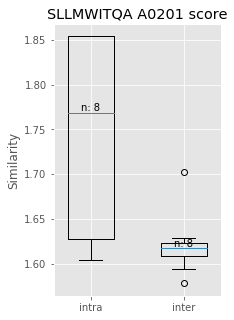

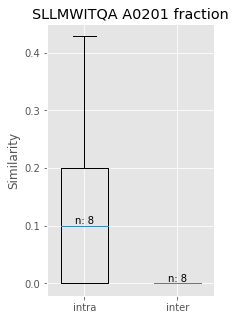

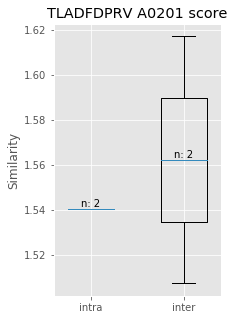

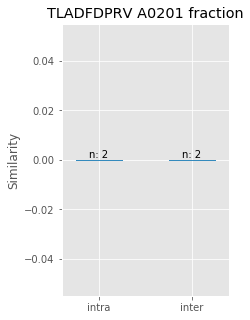

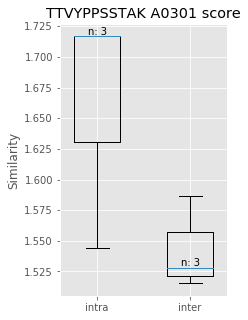

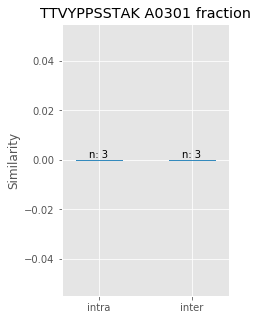

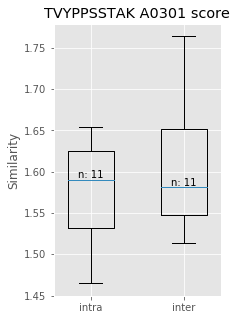

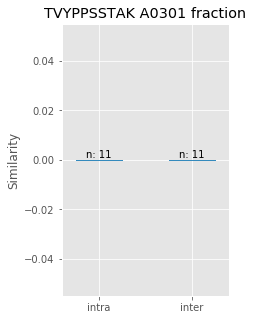

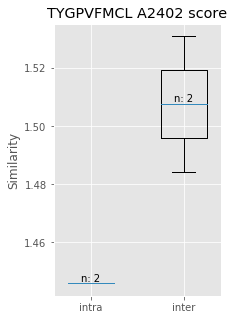

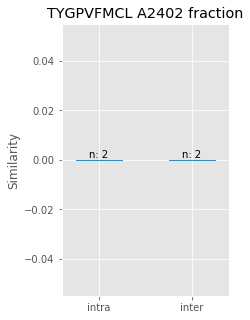

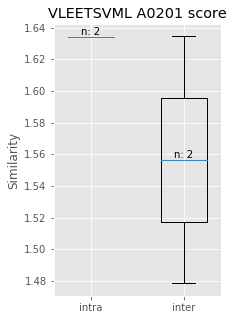

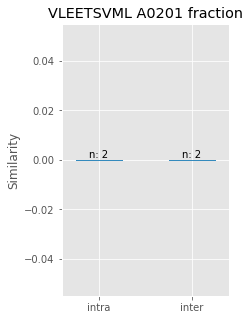

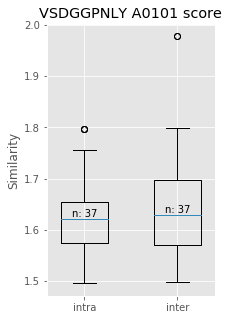

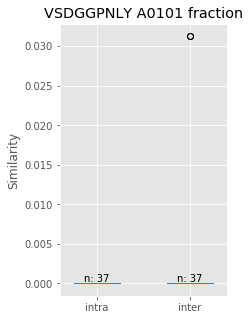

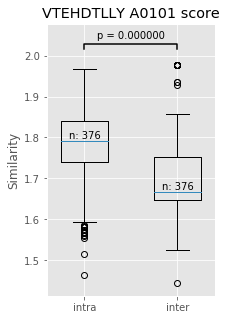

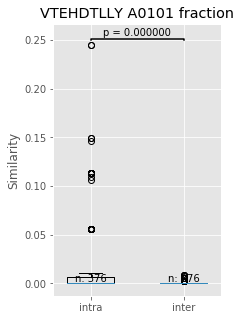

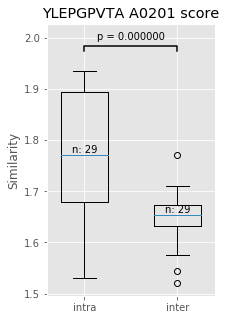

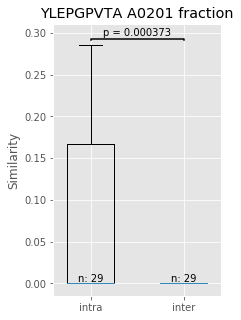

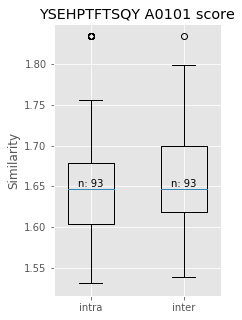

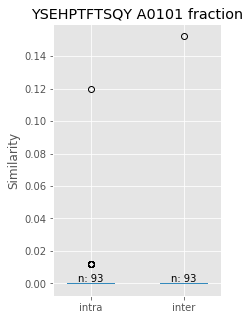

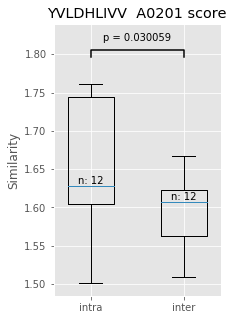

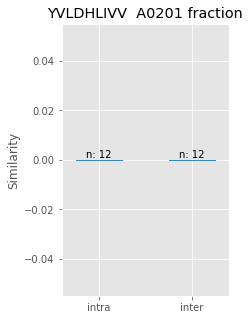

In [43]:
intra_score = list()
inter_score = list()
intra_fract = list()
inter_fract = list()

score_significance = list()
fract_significance = list()

for peptide, group in df.groupby('peptide_HLA'):
    if len(group) == 1:
        continue
    if len(group.drop_duplicates(['cdr3_TRA','cdr3_TRB'])) == 1:
        continue
        
    inter_chains = df.loc[df.peptide_HLA != peptide, ['cdr3_TRA', 'cdr3_TRB']]
    
    intra_score_peptide = list()
    inter_score_peptide = list()  
    intra_fract_peptide = list()
    inter_fract_peptide = list()
    
    cdr3_TRAs = group.cdr3_TRA.values
    cdr3_TRBs = group.cdr3_TRB.values
    
    for index, (a,b) in enumerate(zip(cdr3_TRAs, cdr3_TRBs)):  
        intra = get_intra_similarity(cdr3_TRAs, cdr3_TRBs)
        inter = get_inter_similarity(cdr3_TRAs, cdr3_TRBs)
        
        intra_score_peptide.append(intra['score'])
        inter_score_peptide.append(inter['score'])
        intra_fract_peptide.append(intra['fraction'])
        inter_fract_peptide.append(inter['fraction'])
        
        intra_score.append(intra['score'])
        inter_score.append(inter['score'])
        intra_fract.append(intra['fraction'])
        inter_fract.append(inter['fraction'])
        
    plot_boxplot(intra_score_peptide, inter_score_peptide, peptide + ' score')
    plot_boxplot(intra_fract_peptide, inter_fract_peptide, peptide + ' fraction')
        
    # Statistics
    # Calc p-value for each peptide-plateau (count number of intra significant peptide-plateaus)
    # Count fraction of GEMs above 1.8 similarity
    
    score_significance.append(paired_t_test(intra_score_peptide, inter_score_peptide)['test'])
    fract_significance.append(paired_t_test(intra_fract_peptide, inter_fract_peptide)['test'])

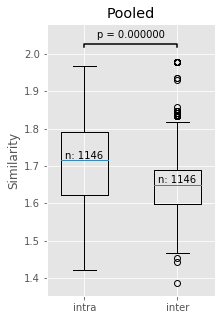

In [44]:
plot_boxplot(intra_score, inter_score, 'Pooled') 

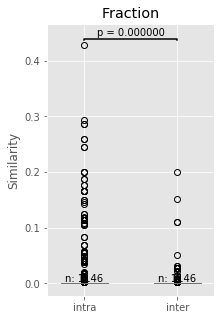

In [45]:
plot_boxplot(intra_fract, inter_fract, 'Fraction')

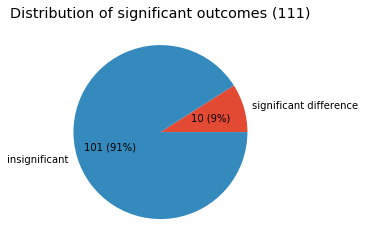

In [46]:
plot_pieplot(score_significance, total_peptides, 'Pooled')

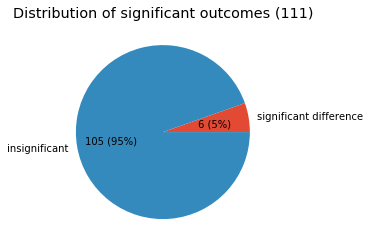

In [47]:
plot_pieplot(fract_significance, total_peptides, 'Fraction')

In [48]:
TYPE

'imputed_new-clonotype'

# All imputed

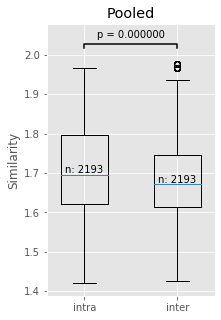

In [22]:
plot_boxplot(intra_score, inter_score, 'Pooled') 

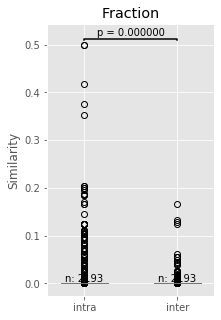

In [23]:
plot_boxplot(intra_fract, inter_fract, 'Fraction')

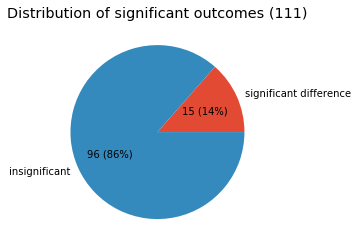

In [24]:
plot_pieplot(score_significance, total_peptides)

In [25]:
sum(score_significance) / total_peptides

0.13513513513513514

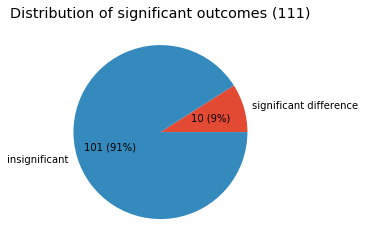

In [26]:
plot_pieplot(fract_significance, total_peptides)

In [27]:
sum(fract_significance) / total_peptides

0.09009009009009009